In [1]:
from PIL import Image
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [3]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [17]:
# Load an image to condition on.
name = "stanley"
img = Image.open('/Users/luoqinpei/Desktop/UCSD_Courses/2025 Winter/CSE 272/Project/images/{}.jpg'.format(name))

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x

0it [00:00, ?it/s]

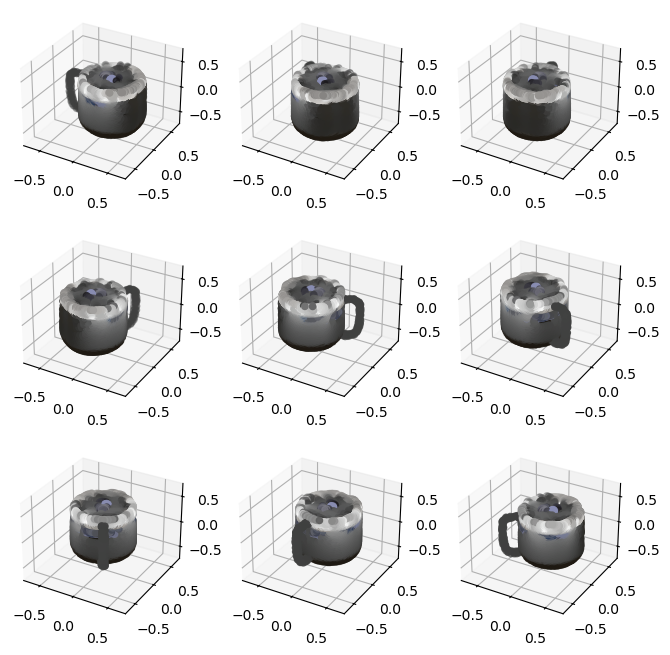

In [18]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))
# Save pc as ply file
with open('/Users/luoqinpei/Desktop/UCSD_Courses/2025 Winter/CSE 272/Project/meshes/{}.ply'.format(name), 'wb') as f:
    pc.write_ply(f)

In [13]:
imgs = []
point_clouds = []
for i in range(1,5):
    imgs.append(Image.open('/Users/luoqinpei/Desktop/UCSD_Courses/2025 Winter/CSE 272/Project/images/{}.jpg'.format(i)))
    # Produce a sample from the model.
    samples = None
    for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
        samples = x
    pc = sampler.output_to_point_clouds(samples)[0]
    point_clouds.append(pc)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
import open3d as o3d
import numpy as np

combined_pcd = o3d.geometry.PointCloud()

for pc in point_clouds:
    pcd = o3d.geometry.PointCloud()
    
    # 提取点云坐标数据
    coords = np.asarray(pc.coords, dtype=np.float64)  # 转换为 NumPy 数组，并确保类型正确
    
    if coords.shape[1] != 3:  # 确保点云数据是 (N, 3) 形状
        raise ValueError(f"点云数据形状错误，期望 (N, 3)，但得到 {coords.shape}")

    pcd.points = o3d.utility.Vector3dVector(coords)  # 转换为 Open3D 点云格式
    combined_pcd += pcd  # 合并

# 显示融合后的点云
o3d.visualization.draw_geometries([combined_pcd])

NameError: name 'point_clouds' is not defined